1. 문제 파악
2. 데이터 탐색  
    - 데이터 시각화
3. 데이터 전처리 
    - 텍스트 데이터 전처리
    - 임베딩
4. 학습
    - 여러 모델 성능 비교
    - 모델 적용
        - test data 임베딩
        - 결과 예측
6. 모델 개선
    - 모델 확정
    - 파라미터 튜닝 (그리드 서치)
    - 결과 예측

# 1. 문제 파악

* Hashcode 사이트의 질문글
:개발자들을 위한 무료 QnA 사이트로 한글인 질문과 전공용어인 영어, 코드의 내용들이 섞여 있는 코퍼스
   : 이러한 특성 때문에 타 말뭉치와 다른 점이 있다면,  
     
    (1) 프로그래밍 전공 용어가 들어간다.   
        : 딥러닝을 사용할 경우 wiki 백과에 각 언어의 설명이나 각종 documentation으로 코퍼스를 수집, pre-trained 된 모델을 가져와 임베딩을 fine-tunning 시킬 수 있다. 하지만 해당 문제는 데이터 개수가 딥러닝을 하기에는 적은 편이어서 딥러닝을 사용하지 않는다.  
        : 분류를 각 (프로그래밍) 언어 별로 하게 되어 있다.
            => 언어에 따라, 타 언어와 유사한 토큰이 등장할 수 있다.
            ==> 따라서 tf-idf 방식으로 임베딩을 진행한다.
    (2) 사용자가 생성하는 것은 정규화된 언어(뉴스 등)가 아니다.
        : 오타나 이모티콘(ㅠㅠ, ㅋㅋ, 등)이 있다.
        : 전공용어는 영어로 질문은 한글로 적는 등, 두 개의 언어가 혼합되어 있다.
    (3) 답을 알려줄만한 노골적인 키워드는 특수문자로 제거되었다. (ex: 파이썬 질문 있어요 -> $$$ 질문 있어요)

필요한 모듈 임포드

In [1]:
# 데이터 처리에 필요한 모듈 임포트
from konlpy.tag import Twitter
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 기계학습에 필요한 모듈 임포드
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# 멀티 라벨 분류 모델 임포트
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [2]:
# 형식이 정해진 글이 아니라 사용자가 임의로 작성하는 글이기 때문에 SNS에서 쓰이는 용어가 조금이라도 있을 수 있다고 판단하여 토크나이저를 정함
twitter = Twitter()

c:\python\venv\nlp\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
c:\python\venv\nlp\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


# 2. 데이터 탐색

데이터 다운로드

In [3]:
path = 'C:\Python\Ground\data\hashcode\hashcode_classification2020_{}.csv'
load = lambda x: pd.read_csv(path.format(x))

In [4]:
sample = load('sample')
test = load('test')
train = load('train')

데이터 확인

In [5]:
train.head()

,title,content,label
0,wait()과 sleep()의 차이점은 뭔가요,###발생하는 문제 및 실행환경\nwait()과 sleep()의 차이점은 뭔가요,3
1,$$$ 초보 외부 클래스 멤버 변수 사용 질문합니다.ㅠㅠ,"1.헤더에, 사용할 멤버변수가 담긴 헤더 파일이 Include 되어있습니다.\n예를...",2
2,ORM: Sequelize: 다대다 관계 쿼리,"안녕하세요.\n\n어떻게 다대다 관계 쿼리를 해야하나요? 예를들어, `product...",4
3,$$$에서 숫자가 NaN인지 검사하려면 어떻게해야하죠?,```\nparseFloat('geoff') == NaN;\n\nparseFloat...,4
4,"$$$ 2.7에서 중국어, 특수문자 인코딩 하는 방법이 뭔가요?",```\n>>>dict['name']\n胡安·马塔\n>>>json.dumps(dic...,5


In [6]:
train.groupby('label').content.count()

label
1    256
2    295
3    919
4    477
5    644
Name: content, dtype: int64

데이터 시각화

In [7]:
label_dict = {1:'C',2:'C++',3:'java',4:'javascript', 5:'python'}
label_names = list(label_dict.values())

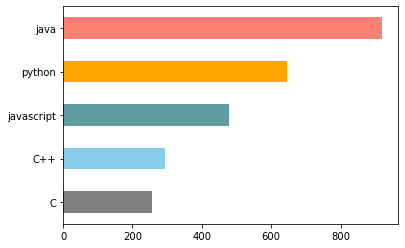

In [8]:
chk_data = train.groupby('label').content.count()
chk_data.index = list(label_dict.values())
colors = ['salmon', 'orange', 'cadetblue', 'skyblue', 'grey'][::-1]
chk_data.sort_values().plot.barh(color = colors);

# 3. 데이터 전처리

### 3-(1) 텍스트 데이터 전처리

In [9]:
def pre(text):
    # 공백 제거, ㅠㅠ ㅋㅋ 등의 감정 표현 이모티콘 제거, 숫자 제거, 이미지 제거
    # 괄호나 :, ; 등의 문자는 각 언어의 특징점이 될 수 있어 그대로 놔둠
    stop1 = re.compile(r'[\t\r\n\v\f,]+')
    stop2 = re.compile(r'[?!#`ㄱ-ㅎㅏ-ㅣ]+|[0-9]+.?[0-9]*|  |(\.|\*|~|;|\| ){2,}|(_|-|=|/|\||\+){4,}')
    stop3 = re.compile(r'\[이미지\]\[?|\[\:|http[a-zA-Z\.:/\-\=]+[(png)|(jpg)|(jpeg)]')

    text = re.sub(stop1, ' ', text)
    text = re.sub(stop2,'', text)
    text = re.sub(stop3,'', text)
    return text

# 주어진 코퍼스를 각 라벨 별로 분류하여, 전체를 한 문서로 보고 데이터 탐색
def make_doc(label_num):
    # 5개 라벨을 기준으로 5개의 문서 만들기
    total = train[train.label==label_num].title+' '+train[train.label==label_num].content
    text = ''
    for i in total:
        text +=' '+str(i)
    text = pre(text)
    return text

def top_k(label,k):
    doc = make_doc(label)
    vect = CountVectorizer().fit([doc])
    count = vect.transform([doc]).toarray().sum(axis=0)
    idx = np.argsort(-count)
    count = count[idx]
    feature_name = np.array(vect.get_feature_names())[idx]
    print(list(zip(feature_name, count))[:k])

In [10]:
k=30
for label in label_dict:
    print('='*100)
    print('코퍼스의 {} 언어에서 TOP {}개 최빈 토큰:'.format(label_dict[label], k))
    top_k(label, k)
    print()

코퍼스의 C 언어에서 TOP 30개 최빈 토큰:
[('int', 866), ('printf', 551), ('if', 356), ('void', 303), ('for', 277), ('char', 259), ('return', 204), ('include', 188), ('null', 159), ('num', 147), ('else', 146), ('str', 141), ('head', 139), ('bit', 136), ('main', 132), ('temp', 128), ('data', 117), ('porta_reg', 110), ('_delay_us', 107), ('while', 107), ('node', 104), ('sizeof', 94), ('stdio', 91), ('arr', 89), ('break', 89), ('struct', 87), ('어떻게', 84), ('scanf', 80), ('us', 72), ('cycle_us', 71)]

코퍼스의 C++ 언어에서 TOP 30개 최빈 토큰:
[('int', 722), ('cout', 384), ('endl', 271), ('if', 259), ('std', 250), ('void', 247), ('return', 217), ('string', 184), ('include', 182), ('for', 156), ('const', 156), ('char', 154), ('class', 137), ('this', 136), ('name', 119), ('public', 116), ('main', 108), ('new', 99), ('어떻게', 98), ('else', 93), ('input', 89), ('case', 85), ('using', 83), ('value', 80), ('size', 75), ('printf', 74), ('node', 72), ('end', 72), ('break', 71), ('iostream', 70)]

코퍼스의 java 언어에서 TOP 30개 최빈 토큰:
[

위의 결과로 각 문서 간 유사도가 높게 나타날 것이라고 예상할 수 있다.

In [11]:
doc1, doc2, doc3, doc4, doc5 = make_doc(1), make_doc(2), make_doc(3), make_doc(4), make_doc(5)

In [12]:
# 문서 토큰화를 미리 진행해보고, '질문글'의 특성 상 나타날 수 밖에 없는 토큰들을 stop_words로 추가한다.
stoplist = ['은','는','이','가','을','를','안','못','의','에서','에는','에서는'
            '로','으로','만','그','같이','다','라는','게','라고'
            '왜','이런','저런','문제','질문',
            '와','과','또는','도',
            '죠',
            '되다','되어다',
            '경우',
            '이렇게',
            '아래','다음'
            '코드','변수','발생','에러','오류','뜨다',
            '해보다','해주다',
            '이다','있다','않다','없다','아니다','싶다','하다','어떻다','모르다',
            '궁금하다','도움','필요하다','부탁드리다','안녕하다','감사하다'
            '예','들다',
            ]

In [13]:
tfidf_corpus = [doc1, doc2, doc3, doc4, doc5]
tfidf_vectorizer = TfidfVectorizer(
    # 너무 희소한 데이터는 그 질문에서만 쓰이는 데이터나 변수명이 될 수 있어 제거
    min_df = 0.05, 
    # 괄호나 기호 등이 코드에서 자주 쓰이고, 이것이 언어의 특징점이 될 수 있어 n-gram 설정
    ngram_range=(1,5),
    # 소문자/대문자를 구별하는 언어가 있기 때문에 소문자화는 진행하지 않는다.
    lowercase=False,
    # '질문글'이라면 흔히 나타날만한 토큰들 (ex. '모르다', '궁금하다')을 stopwords로 추가한다.
    stop_words=stoplist,
    # 코퍼스가 많지 않기 때문에 희소벡터의 수를 줄이기 위해 stemming 실행
    tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True))

tfidf = tfidf_vectorizer.fit_transform(tfidf_corpus)
tfidf.shape

c:\python\venv\nlp\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가다', '감사하다', '늘다', '다음', '라고', '로', '에서는', '예', '오다', '왜', '이렇다', '코드'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(5, 1178832)

밀집벡터로 임베딩 후 각 문서 간 유사도 확인

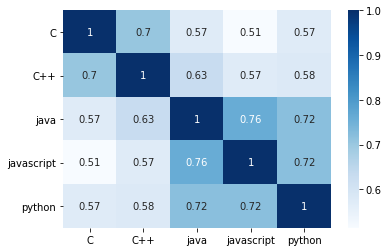

In [14]:
sim = tfidf*tfidf.T
label_names = list(label_dict.values())
sim_df = pd.DataFrame(sim.todense(), columns = label_names, index = label_names)
sns.heatmap(sim_df, annot = True, cmap='Blues')
plt.show()

### 3-(2) 임베딩

In [15]:
title = pd.Series(map(lambda x: pre(str(x)), train.title))
content = pd.Series(map(lambda x: pre(str(x)), train.content))
data = title+content

In [16]:
# 각 문서 간 (언어 간) 유사도가 상당히 높은 편이다. 따라서 tfidf로 임베딩 할 때 max_df 인자를 추가시킨다.
fixed_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    min_df=3,
    max_df=0.8,
    ngram_range=(1,5),
    lowercase=False,
    stop_words=stoplist,
    tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True))

fixed_tfidf = fixed_vectorizer.fit_transform(data)
fixed_tfidf.shape

c:\python\venv\nlp\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['가다', '감사하다', '늘다', '다음', '라고', '로', '에서는', '예', '오다', '왜', '이렇다', '코드'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(2592, 39747)

In [17]:
features = fixed_tfidf.toarray()
labels = train.label

In [18]:
features.shape, labels.shape

((2592, 39747), (2592,))

# 4. 학습

### 4-(1) 여러 모델 성능 비교

In [19]:
models = [RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state=0)
         ]

skf = StratifiedKFold(n_splits=10, shuffle=True , random_state=0)

checks = []
for model in models:
    m_name = model.__class__.__name__
    scores = cross_val_score(model, features, labels, 
                            scoring='accuracy',
                            cv=skf)
    for idx, score in enumerate(scores):
        checks.append((m_name, idx, score))
score_df = pd.DataFrame(checks, columns = ['model_name', 'fold_index', 'score'])
score_df

,model_name,fold_index,score
0,RandomForestClassifier,0,0.565385
1,RandomForestClassifier,1,0.588462
2,RandomForestClassifier,2,0.579151
3,RandomForestClassifier,3,0.610039
4,RandomForestClassifier,4,0.629344
5,RandomForestClassifier,5,0.579151
6,RandomForestClassifier,6,0.575290
7,RandomForestClassifier,7,0.571429
8,RandomForestClassifier,8,0.606178
9,RandomForestClassifier,9,0.629344


In [20]:
mean_score = score_df.groupby('model_name').score.mean()
std_score = score_df.groupby('model_name').score.std()

scrs = pd.concat([mean_score, std_score], axis=1, ignore_index=True)
scrs.columns = ['Mean Score', 'Std']
scrs

,Mean Score,Std
model_name,,
LinearSVC,0.841430,0.022057
LogisticRegression,0.807484,0.027805
MultinomialNB,0.735722,0.026724
RandomForestClassifier,0.593377,0.023688


결과 시각화

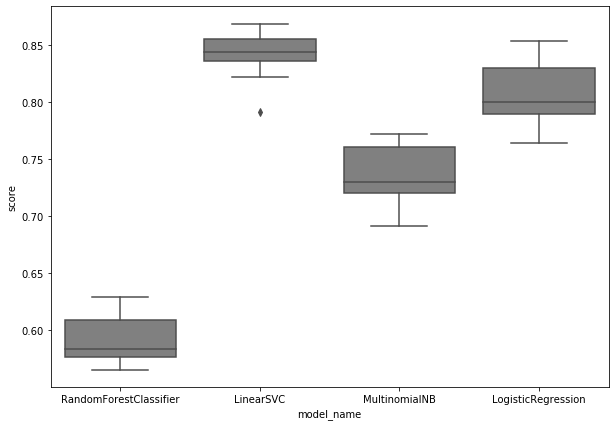

In [21]:
plt.figure(figsize=(10,7))
sns.boxplot(x='model_name', y='score', data=score_df, color = 'grey');

### 4-(2) 모델 적용

In [22]:
# 각 라벨 별 데이터 수가 갇지 않으므로 층화추출법을 사용해서 나눠본다.
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    shuffle = True,
                                                    stratify = labels,
                                                    test_size=0.25,
                                                    random_state = 0)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [23]:
_train = pd.DataFrame({'label':y_train, 'category':'train'}) 
_test = pd.DataFrame({'label':y_test, 'category':'test'}) 
_total = pd.concat([_train, _test])

In [24]:
tfidf.shape

(5, 1178832)

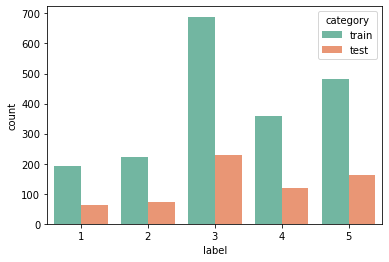

In [25]:
# 적당한 비율로 잘 나눠졌는지 시각화로 확인
sns.countplot(data = _total, x='label', hue = "category", palette = "Set2")
plt.show()
# 층화추출법을 사용해야 함을 확인할 수 있다.

In [26]:
print(metrics.classification_report(y_test, y_pred, target_names=label_names))

              precision    recall  f1-score   support

           C       0.90      0.70      0.79        64
         C++       0.84      0.58      0.69        74
        java       0.80      0.93      0.86       230
  javascript       0.86      0.80      0.83       119
      python       0.88      0.93      0.91       161

    accuracy                           0.84       648
   macro avg       0.86      0.79      0.81       648
weighted avg       0.85      0.84      0.84       648



결과 시각화

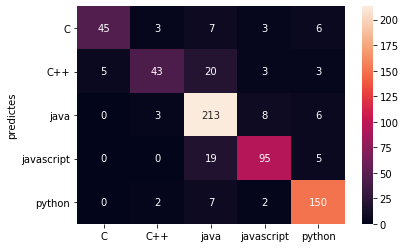

In [27]:
conf = metrics.confusion_matrix(y_test, y_pred)
sns.heatmap(conf, annot=True, fmt='d',
            xticklabels=label_names,
            yticklabels=label_names)
plt.ylabel('actual')
plt.ylabel('predictes');

#### 4-(2)-(a) Test Data 임베딩

In [28]:
title = pd.Series(map(lambda x: pre(str(x)), test.title))
content = pd.Series(map(lambda x: pre(str(x)), test.content))
X_test = title+content
test_vectors = fixed_vectorizer.transform(X_test)

#### 4-(2)-(b) 결과 예측

In [29]:
y_result=model.predict(test_vectors)

In [30]:
y_result

array([5, 4, 1, 3, 5, 3, 5, 4, 3, 3, 2, 5, 5, 1, 5, 3, 4, 1, 1, 3, 3, 5,
       3, 5, 3, 5, 5, 2, 5, 3, 4, 3, 5, 4, 3, 5, 1, 4, 4, 5, 2, 4, 3, 3,
       4, 1, 3, 2, 4, 3, 4, 3, 1, 1, 1, 2, 5, 5, 3, 5, 3, 2, 5, 3, 2, 5,
       3, 4, 3, 3, 3, 5, 3, 2, 4, 4, 3, 5, 2, 3, 1, 1, 3, 4, 3, 4, 4, 5,
       2, 3, 3, 1, 3, 3, 1, 1, 1, 5, 2, 4, 3, 4, 5, 1, 2, 1, 4, 4, 1, 4,
       2, 2, 4, 3, 3, 5, 4, 5, 2, 1, 2, 2, 4, 1, 4, 3, 4, 1, 3, 5, 2, 2,
       2, 3, 4, 3, 5, 3, 3, 1, 5, 5, 5, 5, 3, 3, 3, 3, 3, 5, 4, 3, 2, 3,
       3, 5, 2, 4, 3, 4, 3, 2, 5, 4, 1, 3, 3, 4, 3, 3, 1, 3, 5, 5, 3, 5,
       4, 1, 4, 4, 3, 5, 3, 5, 2, 4, 5, 1, 3, 3, 1, 4, 5, 3, 2, 4, 3, 4,
       1, 4, 1, 3, 3, 5, 3, 2, 2, 4, 3, 4, 1, 1, 2, 3, 1, 5, 1, 5, 3, 4,
       5, 3, 4, 1, 3, 1, 5, 5, 3, 3, 5, 3, 4, 1, 2, 4, 5, 1, 5, 2, 4, 2,
       5, 2, 1, 4, 4, 1, 1, 3, 2, 3, 1, 2, 5, 2, 4, 3, 3, 1, 5, 3, 4, 1,
       5, 1, 3, 3, 3, 3, 5, 5, 3, 3, 4, 1, 2, 4, 1, 1, 2, 5, 1, 1, 5, 1,
       1, 3, 5, 3, 1, 2, 5, 1, 4, 4, 1, 3, 5, 3, 1,

#### 4-(2)-(c) 결과값 저장 후 확인

In [31]:
# pd.DataFrame({'label':y_result}).to_csv('tfidf_pred_1.2.csv',index=False)
# pd.read_csv('tfidf_pred_1.2.csv')

# 5. SVC 모델 개선

### 5-(1) 모델 확정

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
      data, train.label, stratify=train.label, # data는 텍스트 전처리가 끝나있는 상태
      random_state=0, test_size=0.25)

In [33]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

# 빠른 테스트를 위해 세부적인 파라미터는 일단 무시
_pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',SVC())
])
_pipe.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('clf',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,

In [34]:
pipe_train_score = _pipe.score(x_train, y_train)
pipe_test_score = _pipe.score(x_test, y_test)

In [35]:
pipe_train_score, pipe_test_score

(0.9984567901234568, 0.7222222222222222)

In [36]:
parameters = {'clf__kernel':['linear','rbf','poly']}

In [37]:
grid = GridSearchCV(_pipe, parameters, cv=5, n_jobs=-1)

NameError: name 'GridSearchCV' is not defined

In [ ]:
grid.fit(x_train, y_train)

In [ ]:
print('optimal parameter is {}'.format(grid.best_params_))
print('best CV score is {:.3f}'.format(grid.best_score_))
print('best test score is {:.3f}'.format(grid.score(x_test, y_test)))

위의 결과를 통해 linearSVC()를 사용해도 무방하다는 사실을 확인할 수 있다.  
(엄밀히 따지면 SVC(kernel='linear)와 LinearSVC()는 그 결과값이 약간은 다르지만,  
LinearSVC()가 조금 더 빠르고 값이 잘 나온다.)

In [ ]:
def get_score(pipe):
    pipe.fit(x_train, y_train)
    pipe_train_score = pipe.score(x_train, y_train)
    pipe_test_score = pipe.score(x_test, y_test)
    print('train score is {:.4f}'.format(pipe_train_score))
    print('test score is {:.4f}'.format(pipe_test_score))

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',SVC(kernel='linear'))
])
get_score(pipe)

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',LinearSVC())
])
get_score(pipe)

모델을 LinearSVC()로 확정하고, 다음 파라미터 튜닝을 진행한다.

### 5-(2) 그리드서치

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer(tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True))),
    ('tfidf', TfidfTransformer()),
    ('clf',LinearSVC())
])
get_score(pipe)

토크나이저를 사용하면 score가 올라가긴 하지만 연산이 너무 오래 걸린다. 토크나이저를 따로 추가하는 것은 다른 파라미터 튜닝 후, 마지막 단계에서 수행한다.

In [ ]:
TfidfVectorizer().get_params()

In [ ]:
CountVectorizer().get_params()

In [ ]:
TfidfTransformer().get_params()

In [ ]:
LinearSVC().get_params()

In [ ]:
pipe = Pipeline([
    ('vect', TfidfVectorizer(sublinear_tf=True, lowercase=False)),
    ('clf',LinearSVC(random_state=0))
])

컴퓨터 연산량이 부족해, 조금씩 나눠서 시행해본다.

In [ ]:
parameters = {
              'vect__min_df' : [0.001, 0.01, 0.1],
              'vect__max_df' : [0.5, 0.8],
              'vect__ngram_range': [(1, 1),(1, 3),(1, 5)],
              'clf__C' : [0.001, 0.01, 0.1, 1, 10, 100]
             }

grid = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)
print('optimal parameter is {}'.format(grid.best_params_))
print('best CV score is {:.3f}'.format(grid.best_score_))
print('best test score is {:.3f}'.format(grid.score(x_test, y_test)))

In [ ]:
pipe = Pipeline([
    ('vect', TfidfVectorizer(sublinear_tf=True, lowercase=False)),
    ('clf',LinearSVC(random_state=0))
])
parameters = {
              'vect__min_df' : [0.001, 1, 5, 10],
              'vect__max_df' : [0.4, 0.5, 0.6],
              'vect__ngram_range': [(1, 2),(1, 3),(1, 4)],
              'clf__C' : [0.5, 1, 5]
             }

grid = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)
print('optimal parameter is {}'.format(grid.best_params_))
print('best CV score is {:.3f}'.format(grid.best_score_))
print('best test score is {:.3f}'.format(grid.score(x_test, y_test)))

In [ ]:
pipe = Pipeline([
    ('vect', TfidfVectorizer(sublinear_tf=True, lowercase=False)),
    ('clf',LinearSVC(random_state=0))
])
parameters = {
              'vect__min_df' : [1, 2, 3],
              'vect__max_df' : [0.1, 0.3, 0.4],
              'vect__ngram_range': [(1, 2),(1, 3)],
              'clf__C' : list(range(3,8))
             }

grid = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1)
grid.fit(x_train, y_train)
print('optimal parameter is {}'.format(grid.best_params_))
print('best CV score is {:.3f}'.format(grid.best_score_))
print('best test score is {:.3f}'.format(grid.score(x_test, y_test)))

토크나이저를 적용시키고 그리드서치를 할 경우 에러가 발생... 수동으로 찾아준다.

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,2),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True)
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,3),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True)
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,5),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True)
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

위의 결과에서 stopword 커스터마이징의 중요성을 알 수 있다.

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,3),
        lowercase=False,
        tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True)
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5, random_state=0))
])
get_score(pipe)

### 5-(3) 최종 모델 선택 후 결과 예측

In [ ]:
pipe = Pipeline([
    ('vect', CountVectorizer(
        min_df=1, max_df=0.3,
        ngram_range=(1,3),
        lowercase=False,
        stop_words=stoplist,
        tokenizer=lambda x:twitter.morphs(x, norm=True, stem=True)
    )),
    ('tfidf', TfidfTransformer(
        smooth_idf=False,
        sublinear_tf=True)),
    ('clf',LinearSVC(C=5))
])
get_score(pipe)

pipe.fit(x_train, y_train)

In [ ]:
title = pd.Series(map(lambda x: pre(str(x)), test.title))
content = pd.Series(map(lambda x: pre(str(x)), test.content))
X_test = title+content

In [ ]:
y_result=pipe.predict(X_test)

In [ ]:
y_result

In [ ]:
# pd.DataFrame({'label':y_result}).to_csv('tfidf_pred_2.0.csv',index=False)
# pd.read_csv('tfidf_pred_2.0.csv')